# Weakly-Supervised Learning for News Title Classification
## PPgTI - Programa de Pós-Graduação em Tecnologia da Informação
### Author: Frank Laércio da Costa Santos Júnior

## Abstract

This project explores weak supervision techniques for the classification of news headlines using the AG News dataset from Hugging Face. Instead of relying on fully annotated data, this approach leverages programmatic labeling through a set of handcrafted labeling functions (LFs), each capturing different heuristics, patterns, or external cues indicative of a news category (e.g., "World", "Sports", "Business", "Sci/Tech").

To aggregate noisy and potentially conflicting labels from these functions, the project uses a majority voting strategy to generate high-confidence pseudo-labels. These weak labels are then used to train a supervised classifier based on transformer models such as BERT or DistilBERT.

This pipeline enables scalable and cost-effective classification of news titles with minimal human supervision, demonstrating how weak supervision can bridge the gap between unsupervised and fully supervised learning in natural language processing tasks.

__Key Points:__
- Dataset: [AG News (fancyzhx)](https://huggingface.co/datasets/fancyzhx/ag_news)
- Labeling Functions: Heuristic-based and keyword-driven LFs, including domain-specific word lists and pattern-matching rules
- Label Aggregation: Simple majority vote across LFs to generate pseudo-labels
- Modeling: Fine-tuned transformer models on the weak labels
- Evaluation: Performance comparison with a baseline trained on the original labels

### Dataset Overview

In [1]:
import pandas as pd
import os

from huggingface_hub import login
from dotenv import load_dotenv

load_dotenv()

token = os.getenv("HUGGIN_FACE_ACCESS_TOKEN")

if token is None:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face token.")

login(token=token)

/home/franklaercio/.cache/pypoetry/virtualenvs/weakly-labeled-news-ai--KQDVdkK-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset from Hugging Face
df_news = pd.read_parquet("hf://datasets/fancyzhx/ag_news/data/train-00000-of-00001.parquet")
df_news['id'] = range(1, len(df_news) + 1)
df_news

,text,label,id
0,Wall St. Bears Claw Back Into the Black (Reute...,2,1
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,4
4,"Oil prices soar to all-time record, posing new...",2,5
...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,119996
119996,Renteria signing a top-shelf deal Red Sox gene...,1,119997
119997,Saban not going to Dolphins yet The Miami Dolp...,1,119998
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,119999


In [3]:
# Saving the dataset to a local parquet file
df_news.to_parquet("data/data_with_labels.parquet", index=False)

__Labels in the AG News dataset:__
- 0: World
- 1: Sports
- 2: Business
- 3: Science/Technology

In [4]:
# Display the first few rows of the dataset
df_news["label"].value_counts()

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

### Preprocessing

In a real-world weak supervision setting, we assume **true labels are unavailable** during training. Therefore, preprocessing is crucial to ensure that the data is clean, consistent, and suitable for programmatic labeling. 

__Below are the key preprocessing steps applied:__

1) Remove Ground-Truth Labels (Simulate Unlabeled Setting)
To simulate a realistic weak supervision scenario:
- Drop the original labels from the training dataset.
- Retain a **small gold-labeled subset** separately for final evaluation purposes.

2) Clean and Normalize Text
Standardizing text helps labeling functions behave consistently.

- Convert all text to **lowercase**.
- Remove **special characters** and **punctuation** using regex.
- Strip **extra whitespaces** and normalize spacing.

3) Remove Duplicate Titles
Duplicate headlines can:
- Skew label distributions.
- Inflate perceived LF accuracy.
- Introduce bias in training and evaluation.

4) Remove Outliers
Outliers may be:
- Abnormally short or long headlines.
- Garbled or irrelevant text.

5) Filtering out outliers improves label quality and model stability:
- Remove titles with fewer than 3 words or more than 30 words.
- (Optional) Use embedding-based methods to remove semantically anomalous entries.

6) Split Dataset into Train and Development Sets
We split the cleaned dataset into:
- **Training set**: Used for applying labeling functions and model training.
- **Development set**: Used to tune labeling function thresholds and estimate label quality.
- **Typically**, a 80/20 split is used.

7) Create Gold-Labeled Evaluation Set
To measure the effectiveness of weak labels and model performance:
- Sample a **gold set** (e.g., 1,000 examples) from the original labeled data.
- Use only for **final evaluation** — never during training or LF tuning.


In [5]:
# Drop the label column and keep the rest of the dataset
df = df_news.drop(columns=["label"], axis=1)
df

,text,id
0,Wall St. Bears Claw Back Into the Black (Reute...,1
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,4
4,"Oil prices soar to all-time record, posing new...",5
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,119996
119996,Renteria signing a top-shelf deal Red Sox gene...,119997
119997,Saban not going to Dolphins yet The Miami Dolp...,119998
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,119999


In [6]:
# Display a few rows of the dataset
from helpers.dataset import print_random_sample

print_random_sample(df, 50, random_state=271828)

108718 - Pound: Jones Should Lose Olympic Medals (AP) AP - Marion Jones should be stripped of her five Olympic medals if allegations that she used banned drugs before the 2000 Sydney Games are true, World Anti-Doping Agency chief Dick Pound said Friday.

104784 - Newspaper Publishers Padded Sales Figures Investigations have found that several companies inflated circulation totals and revenue in order to keep advertising rates high.

16597 - Ballmer Beats Security Drum BOSTON -- Microsoft CEO Steve Ballmer believes the software industry will create more positive change in the next 10 years than it did in the previous 10 -- provided that security threats are effectively handled.

73156 - 78 die after being arrested in Thailand riots TAKBAI, THAILAND - As many as 78 people were crushed in the aftermath of a riot in southern Thailand, officials said on Tuesday. A prominent Thai pathologist told a news conference that most of the victims 

34023 - Halliburton not notified on contract ban in

In [7]:
# Using lower() to convert the text for each row to lowercase
# This is done to standardize the text data, which can be useful for text processing tasks
df["text"] = df["text"].str.lower()
df

,text,id
0,wall st. bears claw back into the black (reute...,1
1,carlyle looks toward commercial aerospace (reu...,2
2,oil and economy cloud stocks' outlook (reuters...,3
3,iraq halts oil exports from main southern pipe...,4
4,"oil prices soar to all-time record, posing new...",5
...,...,...
119995,pakistan's musharraf says won't quit as army c...,119996
119996,renteria signing a top-shelf deal red sox gene...,119997
119997,saban not going to dolphins yet the miami dolp...,119998
119998,today's nfl games pittsburgh at ny giants time...,119999


In [8]:
from helpers.text import (
    remove_accented_characters,
    remove_excessive_spaces,
    remove_repeated_letters,
    remove_repeated_non_word_characters,
    remove_numbers_punctuation_from_text
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Pipeline to clean text data
# Source: https://github.com/eliasjacob/imd3011-datacentric_ai
# Original author: Elias Jacob
# License: MIT

pipeline_clean_text = Pipeline(
    [
        ("remove_accented_characters", FunctionTransformer(remove_accented_characters)),
        ("remove_excessive_spaces", FunctionTransformer(remove_excessive_spaces)),
        ("remove_repeated_letters", FunctionTransformer(remove_repeated_letters)),
        ("remove_repeated_non_word_characters", FunctionTransformer(remove_repeated_non_word_characters)),
        ("remove_numbers_punctuation_from_text", FunctionTransformer(remove_numbers_punctuation_from_text))
    ]
)

df["text"] = df["text"].apply(pipeline_clean_text.transform)

df

,text,id
0,wall st bears claw back into the black reute...,1
1,carlyle looks toward commercial aerospace reu...,2
2,oil and economy cloud stocks outlook reuters...,3
3,iraq halts oil exports from main southern pipe...,4
4,oil prices soar to all time record posing new...,5
...,...,...
119995,pakistan s musharraf says won t quit as army c...,119996
119996,renteria signing a top shelf deal red sox gene...,119997
119997,saban not going to dolphins yet the miami dolp...,119998
119998,today s nfl games pittsburgh at ny giants time...,119999


In [9]:
# Remove duplicates based on the "text" column
# This is done to ensure that each review is unique in the dataset
df.drop_duplicates(subset=["text"], inplace=True)
df.shape

(119749, 2)

In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Train outlier detector
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso.fit_predict(embeddings)

# Keep only inliers (label = 1)
df = df[outlier_preds == 1]


Batches: 100%|██████████| 3743/3743 [00:34<00:00, 107.66it/s]


In [11]:
# Print the shape of the DataFrame after removing outliers
df.shape

(118551, 2)

In [12]:
# Understanding the distribution of text lengths
df["text"].str.len().describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999])

count    118551.000000
mean        235.733752
std          65.710099
min          96.000000
5%          144.000000
10%         166.000000
25%         196.000000
50%         231.000000
75%         265.000000
80%         274.000000
90%         299.000000
95%         341.000000
98%         406.000000
99%         459.000000
99.9%       724.900000
max        1008.000000
Name: text, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split

# Split dataset into training and development sets
df_train, df_dev = train_test_split(df, test_size=0.2, random_state=42)

# Print the size of the training set
print(f"Train set size: {len(df_train)}")

# Print the size of the combined development and test set
print(f"Dev/Test set size: {len(df_dev)}")

Train set size: 94840
Dev/Test set size: 23711


In [14]:
df_train

,text,id
84130,eight ebay sellers ordered to pay nearly ...,84131
111468,shaq mcgrady pace nba best seller list afp ...,111469
6994,four marines killed in anbar province baghdad ...,6995
58247,chain store sales rise in the oct week new y...,58248
40327,u s are davis cup final underdogs says roddi...,40328
...,...,...
77771,new worm variant spreads clogging e mail ap ...,77772
111605,ibm halts pension plan for new hires ibm ibm ...,111606
104962,european shares open modestly firmer london r...,104963
873,ride this gem amusement park operators have pr...,874


In [15]:
# Saving the datasets to parquet files for further use
df_train.to_parquet("data/train.parquet", index=False)
df_dev.to_parquet("data/dev_test.parquet", index=False)

In [16]:
# Reading the datasets back from parquet files
df_train = pd.read_parquet("data/train.parquet")
df_dev = pd.read_parquet("data/dev_test.parquet")

In [17]:
# Create a DataFrame from the labels list
df_labels = pd.DataFrame(df_news, columns=["label", "id"])

# Display the DataFrame to show the labels and review IDs
df_labels

,label,id
0,2,1
1,2,2
2,2,3
3,2,4
4,2,5
...,...,...
119995,0,119996
119996,1,119997
119997,1,119998
119998,1,119999


In [18]:
# Merge the development and test set with the labeled data
# Source: https://github.com/eliasjacob/imd3011-datacentric_ai
# Original author: Elias Jacob
# License: MIT

# Read the development and test set from a Parquet file
df_dev_test_labeled = pd.read_parquet("data/dev_test.parquet")

# Merge the development and test set with the labeled data
# The labeled data is read from another Parquet file and contains 'review_id' and 'label' columns
# The merge operation joins the two DataFrames on the 'review_id' column
# how='left' ensures that all rows from df_dev_test_labeled are kept, and matching rows from the labeled data are added
df_dev_test_labeled = df_dev_test_labeled.merge(
    pd.read_parquet("data/data_with_labels.parquet")[["id", "label"]],
    on="id",
    how="left",
)

# Drop rows with missing labels
# dropna(subset=['label']) removes rows where the 'label' column is NaN
# This ensures that only labeled data is kept in the DataFrame
df_dev_test_labeled = df_dev_test_labeled.dropna(subset=["label"])

df_dev_test_labeled

,text,id,label
0,ftc pulls plug on infomercial giant the ftc ha...,21257,2
1,u n forces ex soldiers from aristide home u n...,119721,0
2,kenyan environmentalist wins nobel peace prize...,54202,0
3,rugby union lomu still hopeful of return to ac...,86939,1
4,bush announces plan for troop realignment ap ...,1173,0
...,...,...,...
23706,china s space chief coming to us another p...,100384,3
23707,beware bugs can attack net phones they are be...,5959,3
23708,amd s dual core performance boost though about...,51070,3
23709,concern over inventories drives up oil price n...,23418,2


In [19]:
df_dev_test_labeled.shape

(23711, 3)

In [20]:
from sklearn.model_selection import train_test_split

# Split the labeled development/test set into separate development and test sets
# 'test_size=0.5' means we split the data equally into two halves
# 'random_state=271828' ensures reproducibility of the split
# 'stratify=df_dev_test_labeled.label' ensures that the split maintains the same proportion of labels in both sets
df_test, df_dev = train_test_split(
    df_dev_test_labeled,
    test_size=0.5,
    random_state=271828,
    stratify=df_dev_test_labeled.label,
)

# Print the size of the test set
print(f"Test set size: {len(df_test)}")

# Print the size of the development set
print(f"Development set size: {len(df_dev)}")

Test set size: 11855
Development set size: 11856


In [21]:
df_test.label.value_counts(normalize=True)

label
2    0.252889
3    0.249431
0    0.248840
1    0.248840
Name: proportion, dtype: float64

In [22]:
from helpers.dataset import remove_duplicates_and_overlap

df_train, df_dev, df_test = remove_duplicates_and_overlap(df_train, df_dev, df_test)

(94840, 2) (11856, 3) (11855, 3)
(94840, 2) (11856, 3) (11855, 3)
(94840, 2) (11856, 3) (11855, 3)


In [23]:
# Save all files for later use
df_dev.to_parquet("data/dev.parquet", index=False)
df_train.to_parquet("data/train.parquet", index=False)
df_test.to_parquet("data/test.parquet", index=False)

df_train.shape, df_test.shape, df_dev.shape

((94840, 2), (11855, 3), (11856, 3))

In [24]:
df_train = pd.read_parquet("data/train.parquet")
df_dev = pd.read_parquet("data/dev.parquet")
df_test = pd.read_parquet("data/test.parquet")

df_train.shape, df_dev.shape, df_test.shape

((94840, 2), (11856, 3), (11855, 3))

In [25]:
df_train.head()

,text,id
0,eight ebay sellers ordered to pay nearly ...,84131
1,shaq mcgrady pace nba best seller list afp ...,111469
2,four marines killed in anbar province baghdad ...,6995
3,chain store sales rise in the oct week new y...,58248
4,u s are davis cup final underdogs says roddi...,40328


In [26]:
df_dev.head()

,text,id,label
0,arafat flying to paris for treatment ramallah ...,76779,0
1,acquisition of grey puts focus on havas london...,26304,2
2,fusion reactor decision stalled six nations pl...,86192,0
3,the us team is set for spain for the davis cup...,88197,1
4,europe lags behind rest of world on it spend i...,79788,3


In [27]:
# Display a few rows of the dataset
from helpers.dataset import print_random_sample

print_random_sample(df_train, 50, random_state=271828)

74126 - space station crew does some repair work the two man crew of the international space station went outside again for more repair work  gennady padalka and mike fincke spent five and a half hours plugging in new antennas and replaced a worn out piece of cooling equipment 

30188 - mcdonald     s ceos display pattern of chronic disease embattled mcdonald     s has lost its second ceo in the past year after charlie bell resigned today to continue his battle with cancer 

81442 - kmart sells    stores to home depot troy  mich    kmart says the final agreement with the home depot means it     s selling    stores to the home improvement chain for       million 

51240 - update    tokyo stocks open higher  dollar up tokyo stocks opened higher thursday as investors welcomed wall street     s gains  the dollar was up against the japanese yen  the nikkei stock average of     issues was up    

65644 - reports  ca may escape charges in doj deal accounting fraud charges against ca will be d

### Creating Labels Functions

This project uses weak supervision to classify news titles into four categories:
- **World/Politics**
- **Sports**
- **Business/Economy**
- **Sci/Tech**

__Overview__

I created labeling functions (LFs) based on regular expression patterns that capture domain-specific keywords and phrases. These LFs are designed to identify text features typical of each category.

__How the Patterns Work__

- World/Politics: Detects geopolitical terms, political events, elections, international relations, and social issues.
- Sports: Captures sport names, famous teams, player actions, scores, and tournament references.
- Business/Economy: Focuses on financial terms, stock market keywords, company activities, and economic indicators.
- Sci/Tech: Covers space exploration, biology/environment, computing, technology companies, and emerging tech terms.


In [28]:
ABSTAIN = -1
WORLD = 0
SPORTS = 1
BUSINESS = 2
SCI_TECH = 3

In [29]:
# Patterns for each category

world_patterns = [
    # Crime/Legal (for lf_world_crime_legal)
    r"\b(pleads guilty|charges|sexual assault|indecent assault|court|legal case|trial)\b",
    r"\b(kill(s|ed)?|assassinate(d)?)\b",  # With \b word boundary
    # Relationships/Politics (for lf_world_relationships_politics)
    r"\b(security plan|coastal security|foreign policy|diplomacy|geopolitics|embassy|international relations)\b",
    r"\b(iran|north korea|china|us|russia|eu|u\.n\.).*\b(talks|negotiation|sanctions|treaty|dispute|summit)\b",
    r"\b(australian|new zealand|canadian|brazil|panama|iraq(is)?|egyptian(s)?|syria|afghanistan|ukraine).*\b(government|election|protest|conflict|crisis|agreement|relations|border|minister|president)\b",
    # Disasters/Social Issues (for lf_world_disaster_social_issues)
    r"\b(death toll|humanitarian|refugee|famine|aid|human rights|social issue)\b",
    r"\b(storm|hurricane|earthquake|flood|disaster).*\b(toll|victims|relief|emergency|crisis)\b",
    # General (for lf_world_general_keywords and their original patterns)
    r"election(s)?", r"\bvote\b", r"referendum", r"poll(s|ing|ster)?", r"politician", r"politics", r"political",
    r"candidate", r"campaign", r"\bdebate\b", r"opposition", r"protest", r"rebel(s|ion|ions)?", r"warfare",
    r"prime minister", r"president", r"government", r"parliament", r"senate", r"congress", r"legislation",
    r"\bdrug(s)?\b"  # If related to drug policy/trafficking
]

sports_patterns = [
    # Specific Terms (for lf_sports_specific_terms)
    r"\b(football|soccer|basketball|volley(?:ball)?|tennis|baseball|cricket|rugby|hockey|golf|olympics?|athletics|swimming|mma|boxing|f1|formula 1|motogp|esports|cycling)\b",
    r"\b(world cup|champions league|super bowl|grand slam|world series|grand prix|tour de france|wimbledon|us open|stanley cup|nba finals|mls cup|brasileirão)\b",
    r"\b(score[ds]?|goals?|touchdown|home run|point[s]? won|match point|game set match|inning|lap|race|tournament|championship|league|playoff[s]?)\b",
    r"\b(athlete[s]?|player[s]?|team|coach|manager|referee|umpire|fans)\b",  # "manager" may need context
    r"\b(penalty kick|free kick|corner kick|slam dunk|ace \(tennis\)|birdie|bogey|par \(golf\))\b",
    r"\b(pitcher|quarterback|striker|goalkeeper|point guard|forward|defender|pro bowl|mvp|doping|transfer window)\b",
    # Team Names (examples, expand as needed)
    r"\b(manchester united|real madrid|yankees|red sox|lakers|celtics|chiefs|bucs|clemson|virginia|flamengo|corinthians)\b",
    # Player/Team Actions (for lf_sports_player_action)
    r"\b(share[s]? lead|wins|defeats|scores|advances to final|sets record).*\b(tournament|championship|game|match|race)\b",
    r"\b\d+\s*-\s*\d+\b"  # Generic score (may need more context to avoid false positives)
]

business_patterns = [
    # Company Names + Business Context (for lf_business_company_names - one approach is to list companies, another is more generic)
    # For the pattern list approach, it's better to have separate LFs or patterns that combine name AND context.
    # Here, we focus on context terms that can accompany company names:
    r"\b(stock|share[s]?|profit|loss|revenue|earning[s]?|merger|acquisition|ipo|layoff|financial|quarter|results|market|ceo|cfo|board|deal|agreement|growth|down|up|price)\b",  # Financial context
    # Financial Terms (for lf_business_financial_terms)
    r"\b(invest(or|ment|ing)?s?|equity|portfolio|dividend[s]?|securities|trading|broker(age)?)\b",
    r"\b(finance[ds]?|economy|economic|gdp|inflation|interest rate[s]?|recession)\b",
    r"\b(takeover|bid|venture capital|funding|valuation)\b",
    r"\b(chairman|executive|shareholder[s]?)\b",
    r"\b(q\d result[s]?|forecast|outlook \(business\))\b",  # Qualified "outlook"
    r"(\$|us\$|€|gbp|jpy|cny|inr|brl|r\$)\s?\d+([.,]?\d+)*\s?(million|billion|trillion|k|m|b|t)?\b",
    r"\b(compan(y|ies)|corporation[s]?|firm|enterprise|business|industry|sector|multinational|startup)\b",
    r"\b(job[s]?|employment|unemployment|workforce|hiring|payroll)\b",
    r"\b(fdi|tax cut[s]?|budget|tariff|trade|commerce|consumer spending)\b",
    r"\b(airline|carrier)\b",
    # Company Actions (for lf_business_company_actions)
    r"\b(plan|restructuring|strategy|testimony|pressure[s]? unions|accepts deal|announces|reports|expands|cuts jobs|launches)\b"  # Usually with company name
]

sci_tech_patterns = [
    # Space/Astronomy (for lf_sci_tech_space_astro)
    r"\b(nasa|spacex|esa|cnsa|roscosmos|jaxa)\b",
    r"\b(astronaut[s]?|cosmonaut[s]?|spacecraft|rocket|satellite[s]?|probe|space station|iss)\b",
    r"\b(space exploration|space mission|moon landing|mars mission|lunar|martian|interstellar|launch)\b",
    r"\b(astronomy|astronomer[s]?|telescope|hubble|webb|observatory|galaxy|galaxies|cosmos|universe|celestial)\b",
    r"\b(planet[s]?|exoplanet[s]?|star[s]?|comet[s]?|asteroid[s]?|meteor|black hole|nebula|supernova|constellation|orbit)\b",
    r"\b(da vinci project|wildfire rocket)\b",
    # Biology/Environment (for lf_sci_tech_biology_environment)
    r"\b(animal[s]?|plant[s]?|species|wildlife|organism|cell|dna|gene|genome|protein|enzyme|bacteria|virus\(es\)?)\b",
    r"\b(biology|biologist|evolution|genetics|ecology|ecological|ecosystem|biodiversity|conservation|environment|environmental)\b",
    r"\b(climate change|global warming|pollution|renewable energy|solar power|wind power|emissions|carbon footprint)\b",
    r"\b(fossil[s]?|dinosaur[s]?|paleontology|extinction|habitat|migration)\b",
    r"\b(crocodile|moth|insect|bird-like)\b",
    # Computing/Internet/Devices (for lf_sci_tech_computing_internet_devices)
    r"\b(software|hardware|algorithm|code|programming|developer|coding|app[s]?|application[s]?)\b",
    r"\b(internet|online|website|web|cloud computing|data center|server|network|cybersecurity|malware|virus|msblast|phishing|encryption|hacker|hack)\b",
    r"\b(ai|artificial intelligence|machine learning|deep learning|neural network|big data|data science|analytics)\b",
    r"\b(computer[s]?|pc|laptop[s]?|desktop|chip|processor|cpu|gpu|semiconductor|motherboard)\b",
    r"\b(device[s]?|gadget[s]?|wearable[s]?|smartphone[s]?|mobile phone[s]?|iphone|android|ios|tablet|ipad)\b",
    r"\b(ipod|nintendo|playstation|xbox|game console|videogame|gaming|e-sport[s]?)\b",
    r"\b(blu-ray|dvd|hd|high-definition|4k|8k|display|screen|virtual reality|vr|augmented reality|ar)\b",
    r"\b(tech|technology|high-tech|innovation|digital|emerging tech|research and development|r&d)\b",
    # Tech Company Names (overlap with business is a challenge; context is key)
    r"\b(google|microsoft|apple|amazon|facebook|meta|intel|nvidia|samsung|ibm|oracle|cisco|dell|hp|qualcomm|huawei|sony|lg|xiaomi|tivo|netflix|portalplayer|idc|sprint|nextel|ntt docomo|vodafone)\b",
    r"\b(it spending|search marketing|source code|sdk|api|platform|operating system|os|linux|windows|macos|unix)\b",
    r"\b(3g|4g|5g|wi-fi|bluetooth|broadband|fiber optic|internet service|isp)\b",
    r"\b(it infrastructure|information technology)\b"
]


In [30]:
from helpers.lf import int_to_alphabetic_string, create_labeling_functions_from_regex
import re

regex_patterns = []

for i, pattern in enumerate(world_patterns):
    name = f"world_{int_to_alphabetic_string(i + 1)}"
    regex_patterns.append((re.compile(pattern), name, WORLD, ABSTAIN))

for i, pattern in enumerate(sports_patterns):
    name = f"sport_{int_to_alphabetic_string(i + 1)}"
    regex_patterns.append((re.compile(pattern), name, SPORTS, ABSTAIN))

for i, pattern in enumerate(business_patterns):
    name = f"business_{int_to_alphabetic_string(i + 1)}"
    regex_patterns.append((re.compile(pattern), name, BUSINESS, ABSTAIN))

for i, pattern in enumerate(sci_tech_patterns):
    name = f"sci_tech_{int_to_alphabetic_string(i + 1)}"
    regex_patterns.append((re.compile(pattern), name, SCI_TECH, ABSTAIN))

lfs_regex = create_labeling_functions_from_regex(regex_patterns)

lfs_regex

[LabelingFunction lf_regex_world_a, Preprocessors: [],
 LabelingFunction lf_regex_world_b, Preprocessors: [],
 LabelingFunction lf_regex_world_c, Preprocessors: [],
 LabelingFunction lf_regex_world_d, Preprocessors: [],
 LabelingFunction lf_regex_world_e, Preprocessors: [],
 LabelingFunction lf_regex_world_f, Preprocessors: [],
 LabelingFunction lf_regex_world_g, Preprocessors: [],
 LabelingFunction lf_regex_world_h, Preprocessors: [],
 LabelingFunction lf_regex_world_i, Preprocessors: [],
 LabelingFunction lf_regex_world_j, Preprocessors: [],
 LabelingFunction lf_regex_world_k, Preprocessors: [],
 LabelingFunction lf_regex_world_l, Preprocessors: [],
 LabelingFunction lf_regex_world_m, Preprocessors: [],
 LabelingFunction lf_regex_world_n, Preprocessors: [],
 LabelingFunction lf_regex_world_o, Preprocessors: [],
 LabelingFunction lf_regex_world_p, Preprocessors: [],
 LabelingFunction lf_regex_world_q, Preprocessors: [],
 LabelingFunction lf_regex_world_r, Preprocessors: [],
 LabelingF

Enhancing Weak Supervision with Semi-Supervised Learning and BERT Embeddings

In many real-world scenarios, obtaining large volumes of labeled data is expensive and time-consuming. **Weak supervision** helps overcome this by combining noisy sources of supervision (e.g., heuristics, pattern matchers, or distant supervision) into training data. However, these labeling functions (LFs) often lack generalization and can leave many examples unlabeled or inconsistently labeled.

To address these limitations, we incorporate **semi-supervised learning with BERT embeddings** into the weak supervision pipeline.

__Why Use Semi-Supervised Learning?__

**Semi-supervised learning (SSL)** uses both labeled and unlabeled data to improve classification performance. It is especially valuable when:

- You have a small labeled set (e.g., dev set or gold data).
- You have access to a large amount of unlabeled data.
- You want to leverage model predictions on unlabeled data to refine weak labels.

By training a classifier that starts with labeled data and iteratively pseudo-labels the unlabeled set, SSL helps fill in gaps left by LFs.


In [31]:
from transformers import AutoTokenizer, AutoModel

import torch
import numpy as np

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
print(f"Loading tokenizer and model: {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

def get_embeddings_batch(texts, batch_size=16):
    embeddings_list = []

    for i in range(0, len(texts), batch_size):

        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings_list.append(batch_embeddings)

    return np.vstack(embeddings_list)

# Apply to your dataset
X_dev = get_embeddings_batch(df_dev.text.tolist(), batch_size=8)
y_dev = df_dev.label.values

print(f"\nShape of X_dev (Transformer embeddings): {X_dev.shape}")


Using device: cuda
Loading tokenizer and model: bert-base-uncased...

Shape of X_dev (Transformer embeddings): (11856, 768)


__Why Use BERT Embeddings?__

**BERT** provides deep, contextualized representations of text:

- Captures rich semantic meaning beyond surface-level features.
- Handles variations in phrasing or synonyms that keyword-based LFs may miss.
- Embeddings can be used with any classical classifier (e.g., ExtraTrees, Logistic Regression).

Compared to traditional feature extraction (e.g., TF-IDF), BERT embeddings improve generalization and performance, especially in low-data regimes.

In [32]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

# Get embeddings for the labeled development set
X_labeled = get_embeddings_batch(df_dev.text.tolist(), batch_size=8)
y_labeled = df_dev.label.values

# Get embeddings for the unlabeled training set
X_unlabeled = get_embeddings_batch(df_train.text.tolist(), batch_size=8)
y_unlabeled = np.array([-1] * len(df_train))

# Combine embeddings and labels
X_combined = np.vstack([X_labeled, X_unlabeled])
y_combined = np.concatenate([y_labeled, y_unlabeled])

# Initialize and fit SelfTrainingClassifier
base_model = ExtraTreesClassifier(
    random_state=271828,
    n_jobs=-1,
    class_weight="balanced"
)
model_ssl = SelfTrainingClassifier(base_model)

model_ssl.fit(X_combined, y_combined)

SelfTrainingClassifier(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                      n_jobs=-1,
                                                      random_state=271828))

__Use Case in Snorkel__

In Snorkel, the semi-supervised BERT-based model can be wrapped with a `@preprocessor` and added as an additional source of weak supervision. This transforms the model from a purely post-processing step into a **collaborative labeling agent** in the pipeline.

In [33]:
from snorkel.preprocess import preprocessor

@preprocessor(memoize=True)
def semi_superv_classifier(x):
    """
    Preprocess an example by adding a predicted label and score using a semi-supervised model on BERT embeddings.

    Args:
        x: An object with a 'text' attribute.

    Returns:
        x: The same object with added 'label_pred_ssl' and 'score_ssl' attributes.
    """
    # Compute BERT embeddings for the single input text
    embedding = get_embeddings_batch([x.text])  # Returns shape (1, hidden_size)

    # Predict probabilities using the semi-supervised classifier
    pred_proba = model_ssl.predict_proba(embedding)

    # Predicted class index
    pred = np.argmax(pred_proba, axis=1)[0]

    # Assign the predicted label (string, not index)
    x.label_pred_ssl = WORLD if pred == 0 else (
        SPORTS if pred == 1 else (BUSINESS if pred == 2 else SCI_TECH)
    )

    # Assign the score (confidence)
    x.score_ssl = pred_proba[0][pred]

    return x

In [34]:
from helpers.train import train_logistic_regression

conf_matrix = train_logistic_regression(X_dev, y_dev)

F1 Score: 0.8525
Balanced Accuracy: 0.8527
Accuracy: 0.8525
Matthews Corr Coef: 0.8033
Elapsed Time: 16.98s

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2950
           1       0.94      0.94      0.94      2950
           2       0.81      0.80      0.81      2998
           3       0.82      0.81      0.82      2958

    accuracy                           0.85     11856
   macro avg       0.85      0.85      0.85     11856
weighted avg       0.85      0.85      0.85     11856



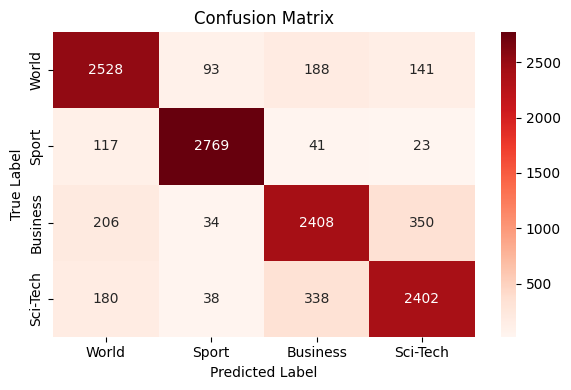

In [35]:
from helpers.plot import plot_confusion_matrix

plot_confusion_matrix(conf_matrix)

In [36]:
from snorkel.labeling import labeling_function


# Define a labeling function that uses the semi-supervised stacked classifier preprocessor
# The @labeling_function decorator indicates that this function is a Snorkel labeling function
# The 'pre' parameter specifies a list of preprocessors to apply before the labeling function
@labeling_function(pre=[semi_superv_classifier])
def lf_ssl(x):
    """
    Labeling function that assigns a label based on the score and predicted label from the semi-supervised stacked classifier.

    Args:
        x: An object with 'score_ssl' and 'label_pred_ssl' attributes added by the semi_superv_classifier preprocessor.

    Returns:
        int: The assigned label (WORLD, SPORTS, BUSINESS, SCI_TECH or ABSTAIN).
    """
    # Apply a threshold to the score to filter out low-confidence predictions
    # If the score is greater than or equal to 0.95, consider the prediction
    if x.score_ssl >= 0.95:
        # If the predicted label is 1, return the WORLD label
        if x.label_pred_ssl == 0:
            return WORLD
        # If the predicted label is 0, return the SPORTS label
        elif x.label_pred_ssl == 1:
            return SPORTS
        # If the predicted label is 2, return the BUSINESS label
        elif x.label_pred_ssl == 2:
            return BUSINESS
        # If the predicted label is 3, return the SCI_TECH label
        elif x.label_pred_ssl == 3:
            return SCI_TECH
    # If the score is less than 0.95, return ABSTAIN to indicate no label
    else:
        return ABSTAIN

In [37]:
# Redeclare the list of labeling functions to include the new one
lfs = lfs_regex + [lf_ssl]

lfs

[LabelingFunction lf_regex_world_a, Preprocessors: [],
 LabelingFunction lf_regex_world_b, Preprocessors: [],
 LabelingFunction lf_regex_world_c, Preprocessors: [],
 LabelingFunction lf_regex_world_d, Preprocessors: [],
 LabelingFunction lf_regex_world_e, Preprocessors: [],
 LabelingFunction lf_regex_world_f, Preprocessors: [],
 LabelingFunction lf_regex_world_g, Preprocessors: [],
 LabelingFunction lf_regex_world_h, Preprocessors: [],
 LabelingFunction lf_regex_world_i, Preprocessors: [],
 LabelingFunction lf_regex_world_j, Preprocessors: [],
 LabelingFunction lf_regex_world_k, Preprocessors: [],
 LabelingFunction lf_regex_world_l, Preprocessors: [],
 LabelingFunction lf_regex_world_m, Preprocessors: [],
 LabelingFunction lf_regex_world_n, Preprocessors: [],
 LabelingFunction lf_regex_world_o, Preprocessors: [],
 LabelingFunction lf_regex_world_p, Preprocessors: [],
 LabelingFunction lf_regex_world_q, Preprocessors: [],
 LabelingFunction lf_regex_world_r, Preprocessors: [],
 LabelingF

### Applying Labels and Understanding Labels Coverage

Once labeling functions (LFs) are defined, they are applied to unlabeled data to create a **label matrix**.

__Labeling Function Performance Analysis__

Analyzing the performance of each labeling function (LF) is a crucial step for refining and improving your weak supervision pipeline. This process includes:

- Understanding the coverage of each labeling function  
- Minimizing conflicts between labeling functions  
- Identifying which functions are making accurate vs. incorrect labels  
- Visualizing conflicts across labeling functions  

In [38]:
from snorkel.labeling import PandasLFApplier

# Create the applier
applier = PandasLFApplier(lfs=lfs)

# Apply labeling functions to the DataFrame
L_train = applier.apply(df=df_train)

100%|██████████| 94840/94840 [32:29<00:00, 48.66it/s]


In [39]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1],
       [-1,  0, -1, ..., -1, -1,  0],
       ...,
       [-1, -1, -1, ..., -1, -1,  2],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], shape=(94840, 74))

In [40]:
L_train.shape

(94840, 74)

In [41]:
# Calculate the coverage of each labeling function
# Coverage is the proportion of data points that a labeling function labels (i.e., does not abstain)
# (L_train != ABSTAIN) creates a boolean matrix where True indicates a non-abstain label
# .mean(axis=0) calculates the mean (coverage) for each labeling function across all data points
coverage = (L_train != ABSTAIN).mean(axis=0)

# Print the coverage of each labeling function
# This helps us understand how often each labeling function is providing a label

for i in range(L_train.shape[1]):
    print(f"LF {lfs[i].name} coverage: {coverage[i] * 100:.2f} %")

LF lf_regex_world_a coverage: 3.41 %
LF lf_regex_world_b coverage: 2.96 %
LF lf_regex_world_c coverage: 0.35 %
LF lf_regex_world_d coverage: 0.90 %
LF lf_regex_world_e coverage: 2.08 %
LF lf_regex_world_f coverage: 1.29 %
LF lf_regex_world_g coverage: 0.19 %
LF lf_regex_world_h coverage: 2.53 %
LF lf_regex_world_i coverage: 0.92 %
LF lf_regex_world_j coverage: 0.15 %
LF lf_regex_world_k coverage: 0.86 %
LF lf_regex_world_l coverage: 0.17 %
LF lf_regex_world_m coverage: 0.18 %
LF lf_regex_world_n coverage: 0.92 %
LF lf_regex_world_o coverage: 0.59 %
LF lf_regex_world_p coverage: 1.13 %
LF lf_regex_world_q coverage: 0.44 %
LF lf_regex_world_r coverage: 0.61 %
LF lf_regex_world_s coverage: 0.63 %
LF lf_regex_world_t coverage: 1.17 %
LF lf_regex_world_u coverage: 0.02 %
LF lf_regex_world_v coverage: 1.91 %
LF lf_regex_world_w coverage: 5.38 %
LF lf_regex_world_x coverage: 3.95 %
LF lf_regex_world_y coverage: 0.45 %
LF lf_regex_world_z coverage: 0.32 %
LF lf_regex_world_aa coverage: 0.56 %


In [42]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_world_a,0,[0],0.034142,0.028258,0.022016
lf_regex_world_b,1,[0],0.029555,0.026898,0.008182
lf_regex_world_c,2,[0],0.003501,0.003279,0.001107
lf_regex_world_d,3,[0],0.008962,0.008330,0.004597
lf_regex_world_e,4,[0],0.020814,0.020561,0.006527
...,...,...,...,...,...
lf_regex_sci_tech_t,69,[3],0.102826,0.099452,0.070603
lf_regex_sci_tech_u,70,[3],0.023534,0.023060,0.013043
lf_regex_sci_tech_v,71,[3],0.005810,0.005567,0.003827
lf_regex_sci_tech_w,72,[3],0.000896,0.000896,0.000801


In [43]:
LFAnalysis(L=L_train, lfs=lfs).label_coverage()

np.float64(0.9162800506115563)

In [44]:
LFAnalysis(L=L_train, lfs=lfs).label_conflict()

np.float64(0.3453922395613665)

In [45]:
L_dev = applier.apply(df=df_dev)

100%|██████████| 11856/11856 [04:03<00:00, 48.70it/s]


In [46]:
L_dev.shape  # The label matrix (L_dev) has 400 data points (rows) and 11 labeling functions (columns).

(11856, 74)

In [47]:
import helpers.plot

# Compute the overlap matrix for the labeling functions and labeled data
results = helpers.plot.plot_coverage_overlap(
    labeling_functions=lfs,
    label_matrix=L_train,
    colorscale="Reds",
    show_values=True,
    sort_by_coverage=True,
)

results["coverage"]

,Labeling Function,Coverage
0,lf_ssl,0.535027
1,lf_regex_business_a,0.268041
2,lf_regex_business_h,0.130631
3,lf_regex_sci_tech_t,0.102826
4,lf_regex_sci_tech_m,0.084827
...,...,...
69,lf_regex_sci_tech_k,0.000274
70,lf_regex_world_u,0.000190
71,lf_regex_sci_tech_f,0.000053
72,lf_regex_sport_i,0.000000


In [48]:
# Perform labeling function analysis using LFAnalysis
# LFAnalysis provides metrics such as coverage, accuracy, and conflict for each labeling function
# L_dev is the label matrix for the development set
# lfs is the list of labeling functions
# df_dev.label.values are the true labels for the development set
lf_summary = LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.label.values)

# Display the summary of the labeling functions' performance
# The summary includes metrics like coverage, accuracy, and conflict
lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_world_a,0,[0],0.034244,0.034244,0.025978,134,272,0.330049
lf_regex_world_b,1,[0],0.029774,0.029774,0.007507,335,18,0.949008
lf_regex_world_c,2,[0],0.003458,0.003458,0.000928,38,3,0.926829
lf_regex_world_d,3,[0],0.010121,0.010121,0.005989,77,43,0.641667
lf_regex_world_e,4,[0],0.020749,0.020749,0.006410,236,10,0.959350
...,...,...,...,...,...,...,...,...
lf_regex_sci_tech_t,69,[3],0.102227,0.102227,0.074140,919,293,0.758251
lf_regex_sci_tech_u,70,[3],0.023026,0.023026,0.013074,243,30,0.890110
lf_regex_sci_tech_v,71,[3],0.007254,0.007254,0.005145,72,14,0.837209
lf_regex_sci_tech_w,72,[3],0.001181,0.001181,0.001012,9,5,0.642857


In [49]:
import helpers

# Compute the conflict matrix for the labeling functions and labeled data
# lfs is the list of labeling functions
# L_train is the label matrix for the training set
conflict_matrix_df = helpers.lf.compute_pairwise_conflict_matrix(labeling_functions=lfs, label_matrix=L_train)

# Display the conflict matrix DataFrame
conflict_matrix_df

,lf_regex_world_a,lf_regex_world_b,lf_regex_world_c,lf_regex_world_d,lf_regex_world_e,lf_regex_world_f,lf_regex_world_g,lf_regex_world_h,lf_regex_world_i,lf_regex_world_j,...,lf_regex_sci_tech_o,lf_regex_sci_tech_p,lf_regex_sci_tech_q,lf_regex_sci_tech_r,lf_regex_sci_tech_s,lf_regex_sci_tech_t,lf_regex_sci_tech_u,lf_regex_sci_tech_v,lf_regex_sci_tech_w,lf_ssl
lf_regex_world_a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001033,0.000422,0.000063,0.000063,0.000590,0.002604,0.000295,0.000485,0.000000,0.005747
lf_regex_world_b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000053,0.000105,0.000011,0.000042,0.000021,0.000169,0.000084,0.000011,0.000000,0.000474
lf_regex_world_c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000032,0.000000,0.000000,0.000000,0.000021,0.000074,0.000000,0.000000,0.000042
lf_regex_world_d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000095,0.000053,0.000011,0.000011,0.000253,0.000401,0.000011,0.000000,0.000021,0.000422
lf_regex_world_e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000053,0.000032,0.000000,0.000011,0.000063,0.000137,0.000011,0.000011,0.000011,0.000190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lf_regex_sci_tech_t,0.002604,0.000169,0.000021,0.000401,0.000137,0.000200,0.000011,0.000179,0.000148,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009722
lf_regex_sci_tech_u,0.000295,0.000084,0.000074,0.000011,0.000011,0.000042,0.000000,0.000053,0.000053,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000411
lf_regex_sci_tech_v,0.000485,0.000011,0.000000,0.000000,0.000011,0.000053,0.000000,0.000011,0.000011,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000179
lf_regex_sci_tech_w,0.000000,0.000000,0.000000,0.000021,0.000011,0.000000,0.000000,0.000011,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000169


In [50]:
helpers.plot.plot_conflict_matrix(conflict_matrix_df)[1]

### Applying Majority Voting and Label Model

1) Majority Voting Algorithm

    The Majority Voting algorithm is a fundamental technique in weak supervision used to aggregate the outputs of multiple labeling functions (LFs) into a single, consolidated label. It is particularly useful when individual LFs may be noisy or inaccurate.

    - Why It Matters
        - **Noise Reduction**: By combining multiple weak signals, majority voting helps reduce label noise and increases reliability.
        - **Conflict Handling**: In cases where labeling functions disagree, the algorithm chooses the most common label, mitigating the effect of incorrect or noisy LFs.
        - **Unsupervised Baseline**: It serves as a simple, unsupervised baseline for evaluating the utility of label functions before introducing more complex probabilistic models.

    - Mathematical Definition

        Let $m$ labeling functions $\lambda_1, \lambda_2, \dots, \lambda_m$, each map a data point $x$ to a label in a set $\mathcal{Y} \cup \{ \emptyset \}$, where $\emptyset$ denotes an abstention (no vote).

        For a given data point $x$, the **Majority Vote label** $\hat{y}_{MV}(x)$ is defined as:

        $$
        \hat{y}_{MV}(x) = \arg\max_{y \in \mathcal{Y}} \sum_{i=1}^{m} \mathbb{1}[\lambda_i(x) = y]
        $$

        where:
        - $\mathbb{1}[\cdot]$ is the indicator function, equal to 1 if the condition is true, 0 otherwise.
        - Ties can be broken randomly or by a predefined rule.

    - Practical Notes
        - If all LFs abstain on a data point, majority voting returns an undefined result (commonly handled as `None` or skipped).
        - This algorithm assumes equal trust in all LFs, which may not hold in practice — that’s where more advanced methods like Snorkel’s label model come in.

2) Label Model

    The **Label Model**, as implemented in Snorkel, is a probabilistic model that **learns the accuracies and correlations** of labeling functions without ground truth labels. It improves upon majority voting by:

    - Why Use the Label Model
        - **Weighting LFs by Accuracy**: The model estimates how trustworthy each LF is and weighs their votes accordingly.
        - **Modeling Dependencies**: It accounts for correlation between LFs to avoid double-counting similar signals.
        - **Probabilistic Labels**: Instead of hard labels, it outputs **label probabilities**, which can be used directly or thresholded for downstream tasks.
    - Intuition
        The Label Model estimates a generative model P(Λ∣Y) over the observed labels from LFs $ \Lambda $, conditioned on the latent true label $ Y $. Using this, it infers $ P(Y | \Lambda) $, the posterior over true labels.

In [51]:
from snorkel.labeling.model import MajorityLabelVoter

# Create a MajorityLabelVoter model with a specified cardinality (number of classes)
# The cardinality is set to 5, which corresponds to the number of classes including abstain
majority_model = MajorityLabelVoter(cardinality=5)

# Fit the model to the label matrix (L_train) and the true labels (df_train.label.values)
preds_train_majority_vote = majority_model.predict(L=L_train, tie_break_policy="random")

In [52]:
# Display the first few rows of the dataset without labels
preds_train_majority_vote

array([2, 1, 0, ..., 2, 2, 2], shape=(94840,))

In [53]:
# Import the LabelModel class from Snorkel's labeling model module
from snorkel.labeling.model import LabelModel

# Calculate the class balance in the development set
# np.bincount(y_dev) counts the number of occurrences of each class in y_dev
# Dividing by len(y_dev) normalizes the counts to get the proportion of each class
class_balance = np.bincount(y_dev) / len(y_dev)

# Initialize a LabelModel with a cardinality of 2 (binary classification) and verbose output
# cardinality=4 indicates the number of classes in the dataset excluding abstain
# verbose=True enables detailed logging during the training process
label_model = LabelModel(cardinality=4, verbose=True)

# Fit the LabelModel using the label matrix L_train
# L_train is a numpy array where each column corresponds to the output of a labeling function
# n_epochs=500 specifies the number of training epochs
# log_freq=50 specifies the frequency (in epochs) of logging the training progress
# seed=271828 ensures reproducibility of the results
# class_balance=class_balance provides the class balance information to the model. If not provided, it will assume uniform class distribution (i.e., equal class weights)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=50, seed=271828, class_balance=class_balance)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  8%|▊         | 38/500 [00:00<00:01, 378.00epoch/s]INFO:root:[50 epochs]: TRAIN:[loss=0.008]
INFO:root:[100 epochs]: TRAIN:[loss=0.004]
 38%|███▊      | 188/500 [00:00<00:00, 667.99epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.003]
INFO:root:[250 epochs]: TRAIN:[loss=0.002]
 66%|██████▌   | 330/500 [00:00<00:00, 679.75epoch/s]INFO:root:[350 epochs]: TRAIN:[loss=0.002]
INFO:root:[400 epochs]: TRAIN:[loss=0.002]
100%|██████████| 500/500 [00:00<00:00, 681.66epoch/s]
INFO:root:Finished Training


In [54]:
from sklearn.metrics import classification_report

# Use the majority model to predict labels for the development set
# L_dev is the label matrix for the development set
# The majority model assigns the most common label among the labeling functions for each example
majority_pred = majority_model.predict(L=L_dev)

# Use the trained label model to predict labels for the development set
# The label model combines the outputs of the labeling functions in a probabilistic manner
snorkel_label_model_pred = label_model.predict(L=L_dev)

# Print the classification report for the majority model
# classification_report computes various metrics (e.g., precision, recall, F1-score) for the predicted labels
# df_dev.label.values contains the true labels for the development set
print(f"Classification report for majority model: \n{classification_report(df_dev.label.values, majority_pred, zero_division=0)}")

# Print the number of abstains (i.e., instances where the majority model did not make a prediction)
# np.count_nonzero(majority_pred == -1) counts the number of -1 values in the predicted labels
print(f"Number of abstains: {np.count_nonzero(majority_pred == -1)}")

# Print an empty line for better readability between reports
print("\n\n")

# Print the classification report for the label model
# This report shows the performance of the label model on the development set
print(f"Classification report for label model: \n{classification_report(df_dev.label.values, snorkel_label_model_pred)}")

# Print the number of abstains for the label model
# This shows how often the label model did not make a prediction
print(f"Number of abstains: {np.count_nonzero(snorkel_label_model_pred == -1)}")

Classification report for majority model: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.97      0.83      0.89      2950
           1       0.99      0.88      0.93      2950
           2       0.93      0.87      0.90      2998
           3       0.97      0.82      0.89      2958

    accuracy                           0.85     11856
   macro avg       0.77      0.68      0.72     11856
weighted avg       0.96      0.85      0.90     11856

Number of abstains: 1404



Classification report for label model: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2950
           1       0.97      0.95      0.96      2950
           2       0.94      0.98      0.96      2998
           3       0.92      0.97      0.95      2958

    accuracy                           0.95     11856
   macro avg       0.95      0.95      0.95     11856
weighted avg       0

In [55]:
# Iterate over the labeling functions and their corresponding weights in the label model
# This code is useful for understanding the contribution of each labeling function to the label model
# It can be used to identify labeling functions that are particularly informative or noisy
for name, weight in zip([lf.name for lf in lfs], label_model.get_weights()):
    # Print the name of the labeling function and its weight as a percentage
    # The weight indicates the importance of the labeling function in the label model
    print(f"{name}: {weight * 100:.2f}%")

lf_regex_world_a: 34.50%
lf_regex_world_b: 100.00%
lf_regex_world_c: 100.00%
lf_regex_world_d: 85.79%
lf_regex_world_e: 100.00%
lf_regex_world_f: 94.07%
lf_regex_world_g: 73.46%
lf_regex_world_h: 93.06%
lf_regex_world_i: 92.31%
lf_regex_world_j: 100.00%
lf_regex_world_k: 75.76%
lf_regex_world_l: 87.32%
lf_regex_world_m: 60.77%
lf_regex_world_n: 79.12%
lf_regex_world_o: 71.54%
lf_regex_world_p: 51.82%
lf_regex_world_q: 53.24%
lf_regex_world_r: 100.00%
lf_regex_world_s: 90.01%
lf_regex_world_t: 100.00%
lf_regex_world_u: 57.10%
lf_regex_world_v: 100.00%
lf_regex_world_w: 74.53%
lf_regex_world_x: 69.94%
lf_regex_world_y: 100.00%
lf_regex_world_z: 39.68%
lf_regex_world_aa: 44.74%
lf_regex_world_ab: 46.91%
lf_regex_world_ac: 22.66%
lf_regex_sport_a: 83.12%
lf_regex_sport_b: 100.00%
lf_regex_sport_c: 97.98%
lf_regex_sport_d: 78.79%
lf_regex_sport_e: 100.00%
lf_regex_sport_f: 88.47%
lf_regex_sport_g: 96.02%
lf_regex_sport_h: 100.00%
lf_regex_sport_i: 100.00%
lf_regex_business_a: 63.69%
lf_rege

/home/franklaercio/.cache/pypoetry/virtualenvs/weakly-labeled-news-ai--KQDVdkK-py3.12/lib/python3.12/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning:

divide by zero encountered in divide



In [56]:
from helpers.plot import analyze_model_predictions

analyze_model_predictions(
    predictions=majority_pred,
    true_labels=df_dev.label.values,
    texts=df_dev.text.values,
    model_name="Majority Model"
)


--- Analysis for Majority Model ---
Number of abstains by Majority Model: 1404
Number of correct predictions by Majority Model: 10076 / 11856
Number of incorrect predictions by Majority Model: 1780 / 11856

Details of incorrect predictions by Majority Model:

Index: 0
Predicted (Majority Model): -1, True: 0
Text: arafat flying to paris for treatment ramallah  west bank   a medical team was flying palestinian leader yasser arafat to france early today for emergency treatment in the clearest sign yet that he is suffering from a severe but still unconfirmed illness that palestinian officials said yesterday could be life threatening 
------------------------------

Index: 14
Predicted (Majority Model): 3, True: 1
Text: birdstone retires after injury elmont  ny  sports network    belmont stakes winner birdstone has been retired because of a bone chip in his left front ankle  the announcement was made on wednesday by the husband of owner marylou whitney 
------------------------------

Inde

In [57]:
from helpers.plot import analyze_model_predictions

analyze_model_predictions(
    predictions=snorkel_label_model_pred,
    true_labels=df_dev.label.values,
    texts=df_dev.text.values,
    model_name="Snorkel Label Model"
)


--- Analysis for Snorkel Label Model ---
Number of abstains by Snorkel Label Model: 0
Number of correct predictions by Snorkel Label Model: 11297 / 11856
Number of incorrect predictions by Snorkel Label Model: 559 / 11856

Details of incorrect predictions by Snorkel Label Model:

Index: 0
Predicted (Snorkel Label Model): 1, True: 0
Text: arafat flying to paris for treatment ramallah  west bank   a medical team was flying palestinian leader yasser arafat to france early today for emergency treatment in the clearest sign yet that he is suffering from a severe but still unconfirmed illness that palestinian officials said yesterday could be life threatening 
------------------------------

Index: 14
Predicted (Snorkel Label Model): 3, True: 1
Text: birdstone retires after injury elmont  ny  sports network    belmont stakes winner birdstone has been retired because of a bone chip in his left front ankle  the announcement was made on wednesday by the husband of owner marylou whitney 
------

__Key Observations:__

1) Accuracy Advantage:
    The Snorkel Label Model outperforms Majority Voting with a ~10% improvement in accuracy (95.3% vs. 85.0%). This suggests that the probabilistic modeling of labeling function accuracies and correlations provides a substantial boost in label quality.

2) No Abstentions:
    The Label Model produces a prediction for every data point, while Majority Voting abstains on ~11.8% of examples (1,404/11,856), likely due to ties or unanimous abstentions from LFs. This makes the Label Model more suitable for full dataset labeling.

3) Error Reduction:
    The Label Model reduces the number of incorrect predictions by over 3× (559 vs. 1,780), which demonstrates its ability to filter out noise and model LF reliability more effectively.

### Conclusion

This project demonstrates the power of weak supervision in natural language processing. By leveraging handcrafted labeling functions (LFs) and advanced techniques, we can effectively classify news titles with minimal human intervention.

A key aspect of this approach involves aggregating the outputs of multiple, potentially noisy, labeling functions. We observed that while a Majority Voting approach provides a straightforward baseline for consolidating these weak labels, the Snorkel Label Model offers a more sophisticated and typically more effective solution. By learning the accuracies and correlations among different LFs, the Label Model generally produces higher-quality probabilistic training labels. This, in turn, can lead to improved performance for downstream models trained on these aggregated labels, underscoring its advantage in harnessing the collective intelligence of the LFs more effectively than a simple majority vote. The results from this project likely highlight this improvement, showcasing the Label Model's ability to better discern signal from noise.

__Future Work__

- Expansion to Datasets with More Classes: Applying this weak supervision framework to datasets with a larger number of categories would test its scalability and the robustness of the LF design. This would likely require more nuanced LFs to distinguish between a greater variety of topics and could reveal new challenges in managing LF conflicts and coverage across a more complex label space.

- Cross-lingual Application (e.g., Portuguese): Adapting and evaluating the system on news titles in other languages, such as Portuguese, would be a valuable next step. This would involve:
    - Revisiting and potentially redesigning LFs to capture linguistic nuances, keywords, and syntactic structures specific to Portuguese.
    - Ensuring that any underlying models (like BERT) are suitable for or fine-tuned on Portuguese text.
    - A key point of curiosity would be to observe if the "activation" patterns of LFs (i.e., their coverage, precision, and how they trigger on relevant text) translate effectively or if significant re-engineering is required. This would provide insights into the cross-lingual generalizability of the weak supervision strategies employed.
- Refinement of Labeling Functions: Continuous iteration on LFs by analyzing their performance (e.g., conflicts, low coverage on certain classes) can further improve the quality of the weak labels.
- Exploring More Advanced LF Combination Techniques: Investigating newer or alternative algorithms for combining LF outputs beyond the current Label Model could yield further improvements.



### References

- DEVLIN, Jacob et al. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. In: CONFERENCE OF THE NORTH AMERICAN CHAPTER OF THE ASSOCIATION FOR COMPUTATIONAL LINGUISTICS: HUMAN LANGUAGE TECHNOLOGIES (NAACL-HLT), 2019, Minneapolis, Minnesota. **Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers)**. Minneapolis, Minnesota: Association for Computational Linguistics, 2019. p. 4171-4186. Disponível em: https://aclanthology.org/N19-1423/. Acesso em: 25 maio 2025.

- EISENSTEIN, Jacob. **Introduction to Natural Language Processing**. Cambridge, MA: The MIT Press, 2019.

- JACOB, Elias. **imd3011-datacentric_ai**. 2023. Repositório GitHub. Disponível em: https://github.com/eliasjacob/imd3011-datacentric_ai. Acesso em: 25 maio 2025.

- JURAFSKY, Dan; MARTIN, James H. **Speech and Language Processing. 3. ed. draft. Stanford: Stanford University, 2023**. Disponível em: https://web.stanford.edu/~jurafsky/slp3/. Acesso em: 25 maio 2025.

- MASSACHUSETTS INSTITUTE OF TECHNOLOGY. Computer Science and Artificial Intelligence Laboratory. **Data-Centric AI**. Cambridge, MA: MIT CSAIL, 2024. Disponível em: https://dcai.csail.mit.edu/2024/. Acesso em: 25 maio 2025.

- MENG, Lingyao et al. WECLASS: **Weakly Supervised Text Classification of Short Texts**. IEEE Access, v. 8, p. 184337-184347, 2020. DOI: 10.1109/ACCESS.2020.3029005. Disponível em: https://ieeexplore.ieee.org/document/9206080. Acesso em: 25 maio 2025.

- RATNER, Alexander J. et al. **Data Programming: Creating Large Training Sets, Quickly. In: CONFERENCE ON NEURAL INFORMATION PROCESSING SYSTEMS (NIPS)**, 30., 2016, Barcelona. Proceedings [...]. Red Hook, NY: Curran Associates, Inc., 2016. p. 3567-3575.

- ZHANG, Jieyu; SONG, Linxin; RATNER, Alexander. Leveraging Instance Features for Label Aggregation in Programmatic Weak Supervision. arXiv preprint arXiv:2201.11663, 2022. Disponível em: https://arxiv.org/abs/2201.11663. Acesso em: 25 maio 2025.